In [5]:
import mediapipe as mp
import cv2
import numpy as np
import functions
import importlib
importlib.reload(functions)
import os
from collections import deque

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [6]:
window_length = 10
allAngles = []
allPoints = []

#Set up different Joints. The value at index 1 is the middle of the joint
JOINTS_TO_TRACK = {
    "left_elbow": [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    "right_elbow": [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    "left_knee": [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    "right_knee": [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    "right_hip": [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER],
    "left_hip": [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER],
    "left_shoulder": [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW],
    "right_shoulder": [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW],
}

#initializes a map to store the x,y,z coordinate of each body part at each frame
landmark_positions = {}
for position in mp_pose.PoseLandmark:
    landmark_positions[position.value] = [[],[],[]]

#Stores the angles calculated at each frame in a different map
angle_history = {joint: [] for joint in JOINTS_TO_TRACK}

script_dir = os.path.dirname(os.path.abspath("../ML Model and Testing/RecordSelf.ipynb"))

In [7]:
cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

    #Store Angle History
    angle_windows = {}

    for joint_name in JOINTS_TO_TRACK.keys():
        # INIT DEQUES TO TAKE THE AVERAGE OF DATA IN A "SLIDING WINDOW"
        # THIS HELPS TO SMOOTH THE DATA. Adjust Window Length to set smoothness
        # of data
        angle_windows[joint_name] = deque([], maxlen=window_length)

    while cap.isOpened():
        ret, frame = cap.read()

        #Detect if video loop is over and update data
        '''if not ret:
            points = {f"landmark_{k}": np.array(v) for k, v in landmark_positions.items()}
            angles = {k: np.array(v) for k, v in angle_history.items()}
            functions.save_lift_data("recordSelf", points, angles, filename_tag="recordSelf")'''


        #Recolor the frame to RGB
        image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        #Recolor the frame back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

        try:
            #EXTRACT LANDMARKS AND APPEND X,Y,Z COORDS TO LANDMARK_POSITIONS
            landmarks = results.pose_landmarks.landmark
            for position in mp_pose.PoseLandmark:
                landmark = landmarks[position.value]
                landmark_positions[position.value][0].append(round(landmark.x,2))
                landmark_positions[position.value][1].append(round(landmark.y,2))
                landmark_positions[position.value][2].append(round(landmark.z,2))

            #GO THRU EACH JOINT GIVEN IN JOINTS_TO_TRACK
            for joint_name, landmark_indices in JOINTS_TO_TRACK.items():

                try: #EXECUTE IF JOINT HAS ACTIVE DATAq
                    a = landmarks[landmark_indices[0].value]
                    b = landmarks[landmark_indices[1].value]
                    c = landmarks[landmark_indices[2].value]

                    # Use only x, y for 2D analysis
                    angle = functions.calculate_angle(
                        [a.x, a.y, a.z],
                        [b.x, b.y, b.z],
                        [c.x, c.y, c.z]
                    )

                    # ADD CURRENT ANGLE AT FRAME TO ANGLE_WINDOWS. IF ANGLE_WINDOWS IS AS LONG AS THE DEQUE EARLIER,
                    # TAKE THE MEAN OF THE DEQUE. DEQUE IS UPDATED AT EACH FRAME, WITH THE FIRST VALUE IN THE DEQUE
                    # BEING REMOVED AS THE LAST IS ADDED (FIFO DATA STRUCTURE)
                    angle_windows[joint_name].append(angle)
                    if len(angle_windows[joint_name]) == window_length:
                        rolling_avg = np.mean(angle_windows[joint_name])
                        angle_history[joint_name].append(int(rolling_avg))

                    #ADD COORDINATES TO VIDEO
                    '''x = a.x * cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                    y = a.y * cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
                    cv2.putText(image, f"{str(round(x ,2))}  {str(round(y,2))} {str(round(a.z,2))}",
                        np.multiply([a.x, a.y-.02], [cap.get(cv2.CAP_PROP_FRAME_WIDTH),cap.get(cv2.CAP_PROP_FRAME_HEIGHT)]).astype(int), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255,255,255), 2, cv2.LINE_AA)'''

                #IF LANDMARK IS NOT FOUND IN FOOTAGE, SET ANGLE TO NOT A NUMBER
                except Exception:
                    angle = np.nan

                #IF WE HAVE AN ACTIVE ANGLE, DISPLAY THE ANGLE ON SCREEN
                if not np.isnan(angle):
                    b_coords = np.multiply([b.x, b.y], [image.shape[1], image.shape[0]]).astype(int)
                    cv2.putText(
                        image,
                        f"{joint_name}: {int(angle)}",
                        tuple(b_coords),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255,255,255),
                        2,
                        cv2.LINE_AA
                    )
        #IF WE CANNOT EXTRACT LANDMARKS, JUST PASS
        except:
            pass

        #DRAW LANDMARKS AND CONNECTIONS IN VIDEO
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                  )
        cv2.imshow('Mediapipe Feed',image)

        #IF USER PRESSES Q, EXIT
        if cv2.waitKey(10) & 0xFF == ord('q'):
            print("User requested exit.")
            points = {f"landmark_{k}": np.array(v) for k, v in landmark_positions.items()}
            angles = {k: np.array(v) for k, v in angle_history.items()}

            functions.save_lift_data("recordSelf", points, angles, filename_tag="recordSelf")
            break




cap.release()
cv2.destroyAllWindows()

User requested exit.


recordSelf_left_elbow: shape = (222,)


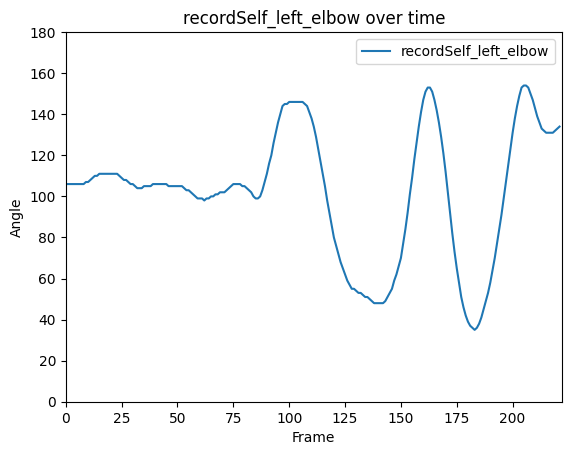

recordSelf_right_elbow: shape = (222,)


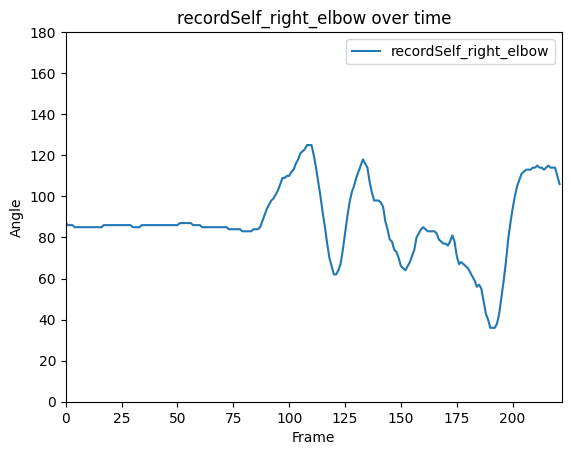

recordSelf_left_knee: shape = (222,)


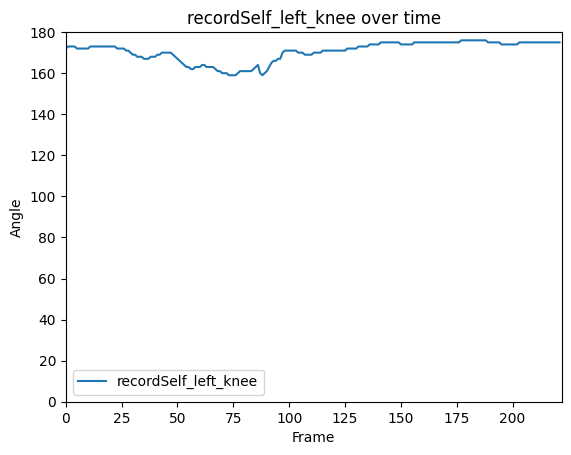

recordSelf_right_knee: shape = (222,)


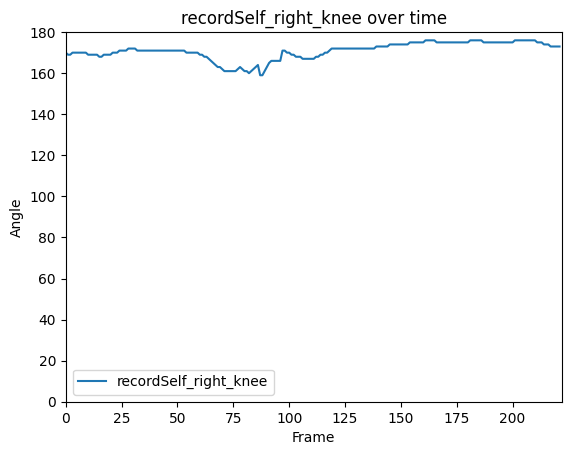

recordSelf_right_hip: shape = (222,)


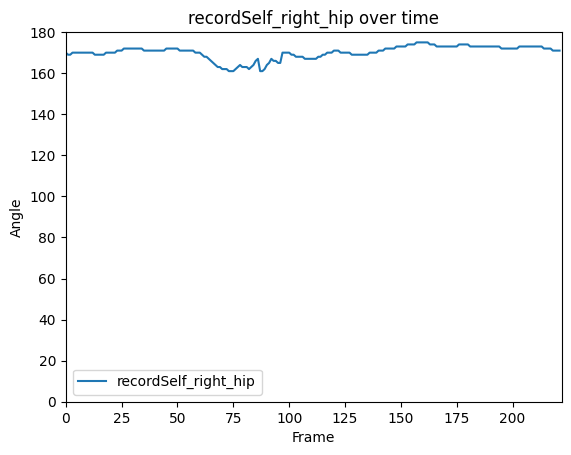

recordSelf_left_hip: shape = (222,)


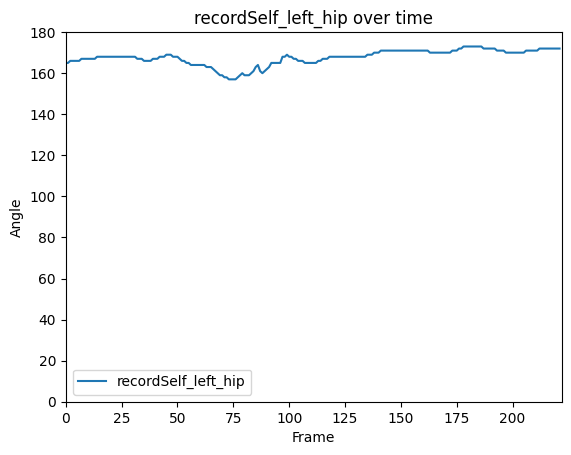

recordSelf_left_shoulder: shape = (222,)


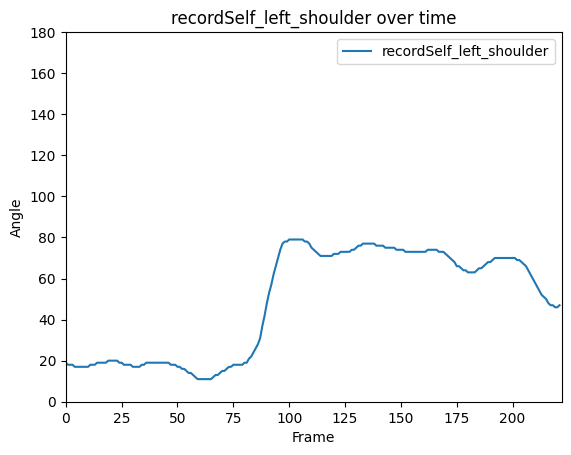

recordSelf_right_shoulder: shape = (222,)


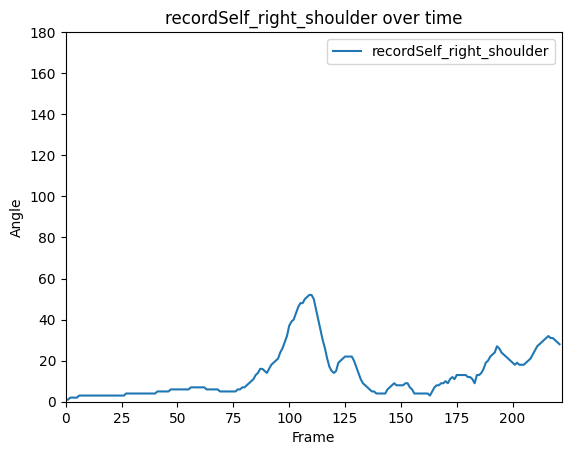

In [8]:
#NPZ VIEWING
import numpy as np
import matplotlib.pyplot as plt

data_dir = os.path.join(script_dir, '..', 'testing data')
data = np.load(f"{data_dir}\\recordSelf files\\recordSelf angles.npz")


for key in data:
    joint_data = data[key]
    print(f"{key}: shape = {joint_data.shape}")
    plt.plot(joint_data, label=key)
    plt.title(f"{key} over time")
    plt.xlabel("Frame")
    plt.xlim(0,joint_data.shape[0])
    plt.ylim(0,180)
    plt.ylabel("Angle")

    plt.legend()
    plt.show()